# Importing Libraries

In [1]:
!pip install transformers
!pip install evaluate
!pip install accelerate -U
!pip install torchmetrics
!pip install optuna
!pip install -U "neptune[optuna]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 936.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel,AutoTokenizer
from tqdm import tqdm
import evaluate
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np
import random
import pandas as pd
from sklearn.utils import shuffle
from torchmetrics.classification import BinaryAccuracy,BinaryConfusionMatrix,BinaryF1Score,BinaryPrecision,BinaryRecall, MulticlassPrecision,MulticlassRecall,MulticlassF1Score
from torchmetrics.collections import MetricCollection
from google.colab import userdata
import neptune
import neptune.integrations.optuna as npt_utils
from neptune.types import File

# Setting up the GPU or CPU

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["NEPTUNE_API_TOKEN"] = userdata.get('NEPTUNE_API_TOKEN')
device = torch.device("cuda:0"  if torch.cuda.is_available() else "cpu")

# Define Variable Values

In [ ]:
# @title Define Transformer Model Name
bert_model_name = "bert-base-cased" # @param {type:"string"}

In [ ]:
# @title Define Hugging Face Dataset Name
dataset_name = "krishan-CSE/HatEval_New" # @param {type:"string"}

In [ ]:
#@title Define Transformer Model Tokenizer Max Padding Length
SEED = 1234
PADDING_MAX_LENGTH = 45 # @param {type:"integer"}

#Configuring Neptuna

In [ ]:
# @title Define Neptuna Project Name,Study ID and Best Trial ID
study_id = "FIN-518" # @param {type:"string"}
trial_id = "FIN-547" # @param {type:"string"}
project_name='krishanchavinda.official/Fine-Tuning-DCL-Framework'# @param {type:"string"}

##Load the Study Run

In [ ]:
run_study = neptune.init_run(with_id=study_id,project=project_name)

<ipython-input-8-d2afc0b94731>:1: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  run_study = neptune.init_run(with_id=study_id,project=project_name)


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-518


## Load the Best Trial Run

In [ ]:
run_trial = neptune.init_run(with_id=trial_id,project=project_name,mode="read-only")

https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-547


In [ ]:
best_prams=run_trial["parameters"].fetch()

# Setting Random Seed for Reproducibility

In [ ]:
def setup_seed(seed:int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    #torch.random.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


In [ ]:
setup_seed(SEED)

# Loading Test Dataset

In [ ]:
data_files = {"test": "test.csv"}
dataset = load_dataset(dataset_name, data_files=data_files)

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 998
    })
})

# Loading the Tokernizer for the Transformer Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

##Define the Tokenizer Function

In [ ]:
def tokenize_function(examples):
    return tokenizer.batch_encode_plus(examples["text"], padding='max_length',max_length=PADDING_MAX_LENGTH,add_special_tokens=True,truncation=True)

## Tokenize the Dataset

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/998 [00:00<?, ? examples/s]

## Remove Unwanted Coloumns

In [ ]:
tokenized_datasets=tokenized_datasets.remove_columns(['text'])

## Format the coloumns

In [ ]:
tokenized_datasets=tokenized_datasets.with_format("torch")

In [ ]:
tokenized_datasets

DatasetDict({
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
})

# Creating DataLoaders for Test Datasets

In [ ]:
test_dataloader=DataLoader(tokenized_datasets["test"], batch_size=best_prams["BATCH_SIZE"] , shuffle=False)

# Define the Dual Contrastive Learning Architecture

In [ ]:
class DCLArchitecture(nn.Module):
    def __init__(self,dropout:float,bert_model_name:str='bert-base-cased'):
        super(DCLArchitecture, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dim = 768
        self.dense = nn.Linear(self.dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self,batch_tokenized, if_train=False):
        input_ids = batch_tokenized['input_ids']
        attention_mask = batch_tokenized['attention_mask']
        bert_output = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        bert_cls_hidden_state = bert_output[1]
        torch.cuda.empty_cache()

        if if_train:
            bert_cls_hidden_state_aug = self.dropout(bert_cls_hidden_state)
            bert_cls_hidden_state = torch.cat((bert_cls_hidden_state, bert_cls_hidden_state_aug), dim=1).reshape(-1, self.dim)
        else:
            bert_cls_hidden_state = self.dropout(bert_cls_hidden_state)

        linear_output = self.dense(bert_cls_hidden_state)
        linear_output = linear_output.squeeze(1)

        return bert_cls_hidden_state, linear_output

## Define Focal Loss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha:float=0.4, gamma:float=2, size_average:bool=True):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.size_average = size_average

    def forward(self, pred, target):

        device = target.device
        self.alpha = self.alpha.to(device)

        pred = nn.Sigmoid()(pred)
        pred = pred.view(-1, 1)
        target = target.view(-1, 1)
        pred = torch.cat((1-pred, pred), dim=1)

        class_mask = torch.zeros(pred.shape[0], pred.shape[1]).to(device)
        class_mask.scatter_(1, target.view(-1, 1).long(), 1.)
        probs = (pred * class_mask).sum(dim=1).view(-1, 1)
        probs = probs.clamp(min=0.0001, max=1.0)

        log_p = probs.log()
        alpha = torch.ones(pred.shape[0], pred.shape[1]).to(device)
        alpha[:, 0] = alpha[:, 0] * (1 - self.alpha)
        alpha[:, 1] = alpha[:, 1] * self.alpha
        alpha = (alpha * class_mask).sum(dim=1).view(-1, 1)

        batch_loss = -alpha * (torch.pow((1 - probs), self.gamma)) * log_p

        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()

        return loss

# Evaluate with Test Dataset

In [ ]:
def test_loop(model, test_dataloader,criteon, device,average:str="macro"):
    collection_metric = MetricCollection(
          BinaryAccuracy(),
          MulticlassPrecision(num_classes=2,average=average),
          MulticlassRecall(num_classes=2,average=average),
          MulticlassF1Score(num_classes=2,average=average),
    )
    collection_metric.to(device)
    bcm_metric = BinaryConfusionMatrix()
    bcm_metric.to(device)
    model.eval()
    predictions = torch.tensor([], device=device)
    targets = torch.tensor([], device=device)
    total_test_loss = 0.0
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]
        with torch.no_grad():
            emb, pred = model(batch , False)
            loss = criteon(pred, labels.float())
            pred = torch.sigmoid(pred)
        total_test_loss += loss.item()
        predictions = torch.cat((predictions, torch.round(pred)), 0)
        targets = torch.cat((targets, labels), 0)
    average_epoch_test_loss = total_test_loss / len(test_dataloader)  # Compute average epoch loss
    result =  collection_metric(predictions,targets)
    bcm_metric(predictions,targets)
    collection_metric.reset()
    return average_epoch_test_loss,result,bcm_metric

##Load the DCL Model and Focal Loss

In [ ]:
model = DCLArchitecture(bert_model_name=bert_model_name,dropout=best_prams["DROPOUT"])
model.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

DCLArchitecture(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
criteon = FocalLoss(best_prams["ALPHA"],best_prams["GAMMA"])

## Load the Best Trail Checkpoint

In [ ]:
def load_checkpoint(run: neptune.Run,check_point_name:str):
    model_ext = run[check_point_name]["model"].fetch_extension()
    criteon_ext = run[check_point_name]["criteon"].fetch_extension()
    run[check_point_name]["model"].download()  # Download the checkpoint
    run[check_point_name]["criteon"].download()
    run.wait()
    # Load the checkpoint
    checkpoint = {
        "model_state_dict":torch.load(f"model.{model_ext}"),
        "criteon_state_dict":torch.load(f"criteon.{criteon_ext}")
    }
    return checkpoint

In [ ]:
check_point_name="model_checkpoints/"

In [ ]:
checkpoint=load_checkpoint(run_trial,check_point_name)

In [ ]:
criteon.load_state_dict(checkpoint["criteon_state_dict"])

<All keys matched successfully>

In [ ]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

## Test the model with Test Set

In [ ]:
average_epoch_test_loss,result_metrics,bcm_metric=test_loop(model, test_dataloader,criteon, device)

In [ ]:
result_metrics

{'BinaryAccuracy': tensor(0.7455, device='cuda:0'),
 'MulticlassPrecision': tensor(0.7461, device='cuda:0'),
 'MulticlassRecall': tensor(0.7513, device='cuda:0'),
 'MulticlassF1Score': tensor(0.7443, device='cuda:0')}

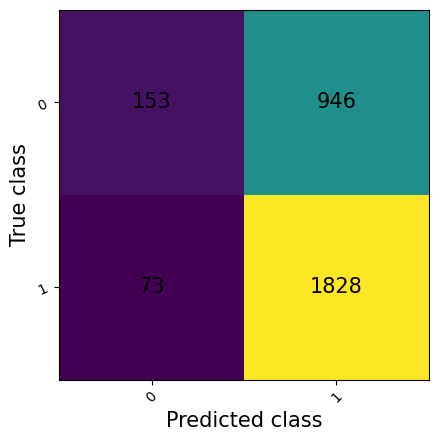

In [ ]:
fig, ax = bcm_metric.plot()

In [ ]:
result_metrics

{'BinaryAccuracy': tensor(0.7044, device='cuda:0'),
 'BinaryPrecision': tensor(0.6812, device='cuda:0'),
 'BinaryRecall': tensor(0.8048, device='cuda:0'),
 'BinaryF1Score': tensor(0.7378, device='cuda:0')}

In [ ]:
result={
    "Accuracy":result_metrics["BinaryAccuracy"].item(),
    "Loss":average_epoch_test_loss,
    "Precision":result_metrics["BinaryPrecision"].item(),
    "Recall":result_metrics["BinaryRecall"].item(),
    "F1Score":result_metrics["BinaryF1Score"].item(),
    "confustion_matrix":fig
}

## Upload the Test Results to Neptuna

In [ ]:
def upload_test_metrics(result,run: neptune.Run):
    run["Test_Result/Accuracy"]=result["Accuracy"]
    run["Test_Result/Loss"]=result["Loss"]
    run["Test_Result/Precision"]=result["Precision"]
    run["Test_Result/Recall"]=result["Recall"]
    run["Test_Result/F1Score"]=result["F1Score"]
    run["Test_Result/confustion_matrix"].upload(result["confustion_matrix"])
    run.wait()
    print("Upload Succesfull")


In [ ]:
upload_test_metrics(result,run_study)

Upload Succesfull


In [ ]:
run_trial.stop()
run_study.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-27/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-26/metadata
